In [2]:
import os
import random
import numpy as np
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.models import Model, Sequential 
from keras.layers import Input, Dense, Flatten, Dropout, LeakyReLU, BatchNormalization, Conv2D, MaxPool2D
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, confusion_matrix
%matplotlib inline
print ("TensorFlow version: " + tf.__version__)

Using TensorFlow backend.


TensorFlow version: 1.13.1


In [15]:
# Final image resolution
res = 64

# Crop images to squares
def to_square(img):
    (h, w) = img.shape
    diff_half = np.abs(h-w) // 2
    
    if w > h:
        return(img[0:h, 0+diff_half:w-diff_half])
    elif w < h:
        return(img[0+diff_half:w-diff_half, 0:w])
    else: 
        return img

def load_data(dataset='train'):
    
    # Path where files are stored
    files_path = 'data/chest_xray/'+dataset
    
    #--- STEP 1: Create list containing names of image files ---#
    names_list = []
    for cat in ['/NORMAL', '/PNEUMONIA']:
        for img_name in os.listdir(files_path+cat):
            # Exclude non-image files
            if img_name[0] in ['I', 'N', 'p']:
                names_list.append(img_name)
    # Shuffle to feed into network
    random.Random(232).shuffle(names_list)
    
    #--- STEP 2: Create list of labels ---#
    labels = []
    for img_name in names_list:
        # 0 for normal, 1 for pneumonia
        if img_name[0] in ['I', 'N']:
            labels.append(0)
        elif img_name[0] == 'p':
            labels.append(1)
            
    #--- STEP 3: Load images and process them ---#
    img_list = []
    for img_name in tqdm(names_list):
        try:
            # Load images 
            if img_name[0] in ['I', 'N']:
                img = plt.imread(files_path+'/NORMAL/'+img_name)
            elif img_name[0] == 'p':
                img = plt.imread(files_path+'/PNEUMONIA/'+img_name)
                
            # Process images (normalize, square, reduce resolution)
            if len(img.shape) == 3:
                img = img[:,:,0]
            img = img / 255
            img = to_square(img)
            img = cv2.resize(img, dsize=(res, res), interpolation=cv2.INTER_AREA)
            img = img.reshape(res, res, 1)
            img = np.dstack([img, img, img])
            img_list.append(img)
        except OSError:
            pass
    
    return np.array(img_list), np.array(labels)

In [16]:
# Load data into each dataset pair
x_train, y_train = load_data(dataset='train')
x_val, y_val = load_data(dataset='val')
x_test, y_test = load_data(dataset='test')

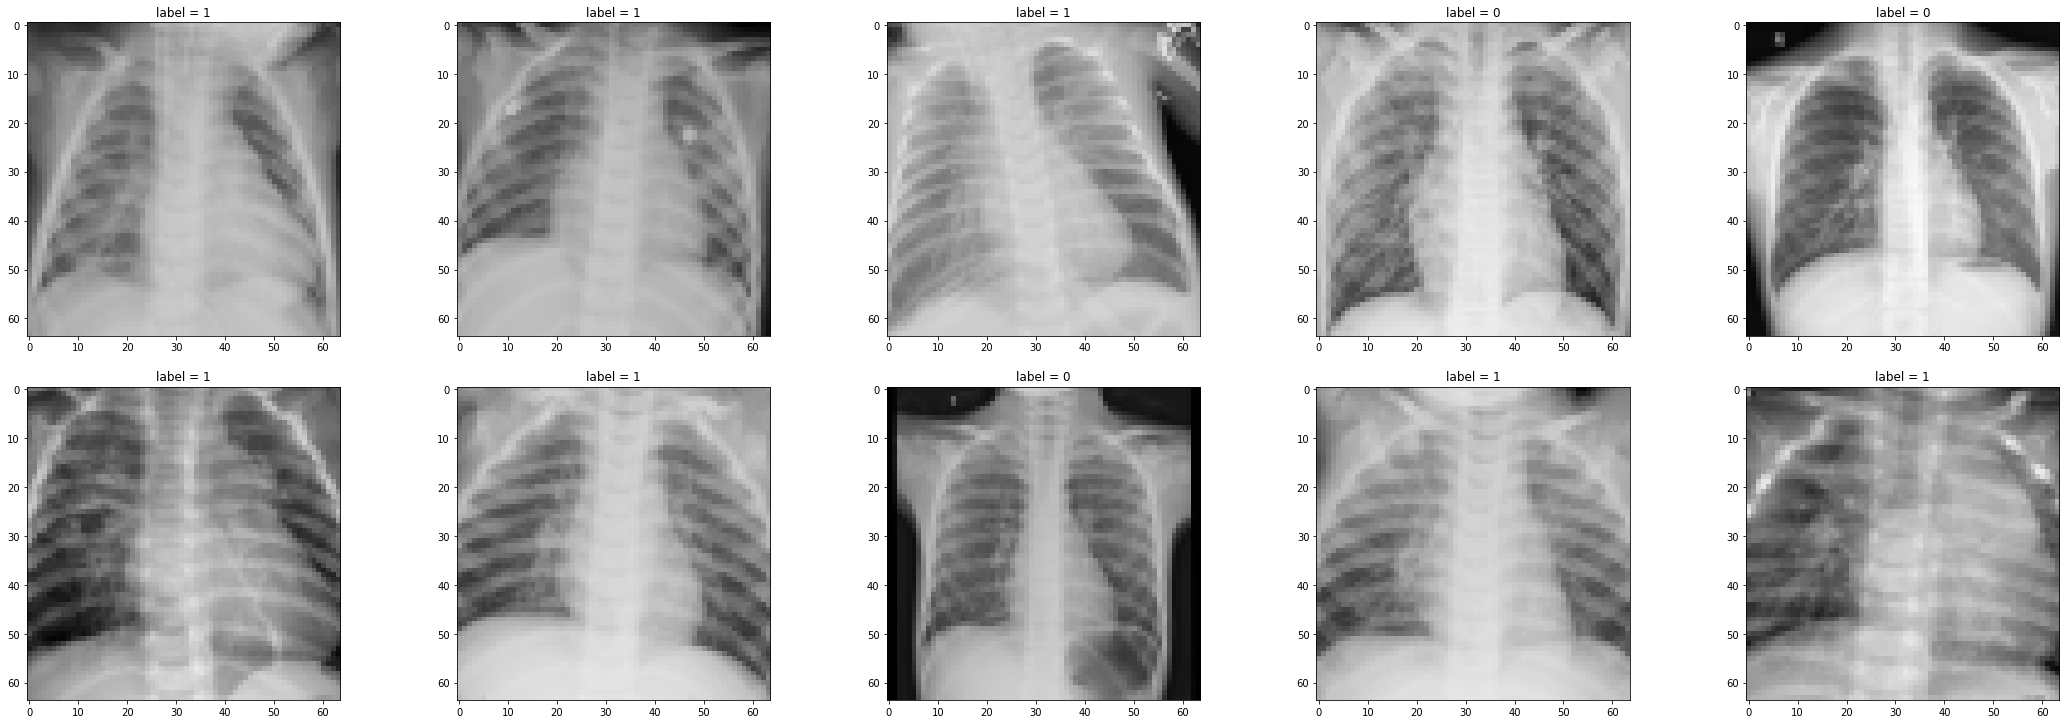

In [17]:
# Visualizing xrays
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30, 10))
ax = ax.ravel()
plt.tight_layout(h_pad=3)

for i in range(ax.shape[0]):
    ax[i].imshow(x_test[i], cmap='gray')
    ax[i].set_title('label = {}'.format(y_test[i]))

In [18]:
# Model parameters
ks33 = (3, 3)
ks22 = (2, 2)

In [19]:
# Design model with Keras Funcitonal API 
inputs = Input(shape=(res, res, 3))

# Convolutional layer 1
conv1 = Conv2D(filters=16, kernel_size=ks33, activation='relu', padding='same')(inputs)
conv1 = Conv2D(filters=16, kernel_size=ks33, activation='relu', padding='same')(conv1)
conv1 = MaxPool2D(pool_size=(2, 2))(conv1)

# Convolutional layer 2
conv2 = Conv2D(filters=32, kernel_size=ks33, activation='relu', padding='same')(conv1)
conv2 = Conv2D(filters=32, kernel_size=ks33, activation='relu', padding='same')(conv2)
conv2 = BatchNormalization()(conv2)
conv2 = MaxPool2D(pool_size=(2, 2))(conv2)

# Convolutional layer 3
conv3 = Conv2D(filters=64, kernel_size=ks33, activation='relu', padding='same')(conv2)
conv3 = Conv2D(filters=64, kernel_size=ks33, activation='relu', padding='same')(conv3)
conv3 = BatchNormalization()(conv3)
conv3 = MaxPool2D(pool_size=(2, 2))(conv3)

# Fully-Connected layer
fc = Flatten()(conv3)
fc = Dense(units=256, activation='relu')(fc)
fc = Dropout(rate=0.5)(fc)
fc = Dense(units=64, activation='relu')(fc)
fc = Dropout(rate=0.2)(fc)

# Output
output = Dense(units=1, activation='sigmoid')(fc)

# Create model and compile
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
# Model summary
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
__________

In [21]:
# Callbacks and image preprocessing

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
img_aug = ImageDataGenerator(rotation_range=20, vertical_flip=True, horizontal_flip=True)
img_aug.fit(x_train)

In [22]:
# Hyperparameters for fitting
batch_size = 74
epochs = 7
steps = x_train.shape[0] // batch_size

# Fitting model to data (val set too small, use test for validation)
model.fit_generator(img_aug.flow(x_train, y_train, batch_size=batch_size), 
                    steps_per_epoch=steps, epochs=epochs, 
                    validation_data=(x_test, y_test), callbacks=[reduce_lr], 
                    verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/7
70/70 [==============================] - 61s 874ms/step - loss: 0.2972 - acc: 0.8905 - val_loss: 0.5335 - val_acc: 0.7292
Epoch 2/7
70/70 [==============================] - 57s 810ms/step - loss: 0.2048 - acc: 0.9272 - val_loss: 0.8631 - val_acc: 0.7276
Epoch 3/7
70/70 [==============================] - 56s 807ms/step - loss: 0.1770 - acc: 0.9334 - val_loss: 0.8567 - val_acc: 0.7147
Epoch 4/7
70/70 [==============================] - 57s 817ms/step - loss: 0.1527 - acc: 0.9413 - val_loss: 2.7700 - val_acc: 0.6554
Epoch 5/7
70/70 [==============================] - 59s 843ms/step - loss: 0.1509 - acc: 0.9442 - val_loss: 5.8704 - val_acc: 0.6250
Epoch 6/7
70/70 [==============================] - 58s 827ms/step - loss: 0.1429 - acc: 0.9479 - val_loss: 0.9219 - val_acc: 0.7660
Epoch 7/7
70/70 [==============================] - 62s 880ms/step - loss: 0.1456 - acc: 0.9442 - val_loss: 0.5875 - val_acc: 0.6891

Epoch 00007: ReduceLROnPlat

In [23]:
# Metrics

# Getting predictions
predictions = model.predict(x=x_test)

acc = accuracy_score(y_test, np.round(predictions))*100
tn, fp, fn, tp = confusion_matrix(y_test, np.round(predictions)).ravel()

print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(tp/(tp+fp)*100))
print('Recall: {}%'.format(tp/(tp+fn)*100))

Accuracy: 68.91025641025641%
Precision: 82.23684210526315%
Recall: 64.1025641025641%
